In [1026]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import norm

In [1027]:
#Loading the cleaned data from the EDI step
data = pd.read_csv("../Data/features.csv", index_col = 0)

In [1028]:
print(f"Features selected for the models: \n\n{data.columns}")

Features selected for the models: 

Index(['Month', 'Habitat_type_classLV2', 'HABITAT_CD', 'Year', 'Depth', 'SST',
       'NPP', 'Depth_Sbrocco', 'Deepwater', 'FSA', 'Marina_slips_10km',
       'Marina_slips_25km', 'Population_50km', 'Recreational_fishermen_50km',
       'SG_permits_50km', 'SG_charter_permits_25km',
       'Commercial_pounds_landed', 'impact',
       'transformed_right_Diversity_index', 'transformed_right_Wave_exposure',
       'transformed_Total_gravity', 'transformed_Tourist_fishing',
       'transformed_Nursery_mangroves', 'transformed_Coral_area_UFRTM_20km',
       'transformed_Pop_per_area_reef_20km', 'transformed_Reef_complexity',
       'transformed_Coral_cover'],
      dtype='object')


### Discretization

In order to discretize Diversity_index, we start by analysing its distribuition:

In [1032]:
data.transformed_right_Diversity_index.describe()

count    2577.000000
mean       -0.013601
std         0.989743
min       -11.324669
25%        -0.628469
50%        -0.054752
75%         0.559857
max         2.606714
Name: transformed_right_Diversity_index, dtype: float64

C:\Users\cetle\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


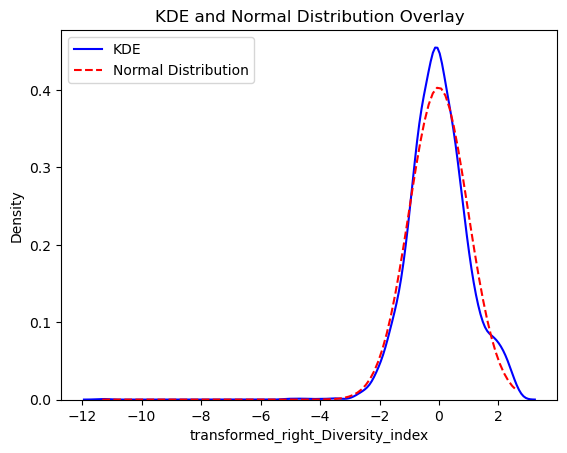

In [1033]:
# Create the KDE plot
sns.kdeplot(data.transformed_right_Diversity_index, label="KDE", color='blue')
 
# Create the overlay for the normal distribution
# Get mean and standard deviation of the data
mean, std = np.mean(data.transformed_right_Diversity_index), np.std(data.transformed_right_Diversity_index)
 
# Generate points for the normal distribution
x = np.linspace(min(data.transformed_right_Diversity_index), max(data.transformed_right_Diversity_index), 100)
pdf = norm.pdf(x, mean, std)
 
# Plot the normal distribution
plt.plot(x, pdf, label="Normal Distribution", color='red', linestyle='--')
 
# Add labels and legend
plt.legend()
plt.title("KDE and Normal Distribution Overlay")
plt.show()

* As shown in the plot, the distribution seems to have a long left tail, with most of the data concentrated on the right, where we have the peak. 

* The mean is closer to the higher values on the right.

* The plot above show a clear fit between the transformed diversity index with the expected normal distribution.

In [1035]:
data.transformed_right_Diversity_index.describe()

count    2577.000000
mean       -0.013601
std         0.989743
min       -11.324669
25%        -0.628469
50%        -0.054752
75%         0.559857
max         2.606714
Name: transformed_right_Diversity_index, dtype: float64

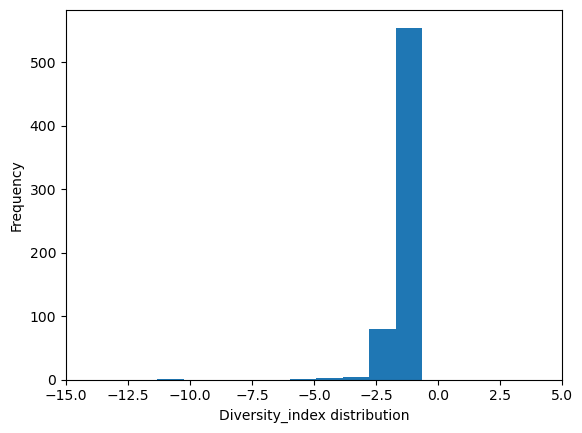

In [1036]:
#Checking values are bellow the the Q25.
threshold = data.transformed_right_Diversity_index.quantile(0.25)

#Identify possible outlier
possible_outliers = data[data["transformed_right_Diversity_index"] < threshold]

#Plotting the distribution of possible outliers
possible_outliers["transformed_right_Diversity_index"].plot.hist()
plt.xlabel("Diversity_index distribution")
plt.xlim(-15, 5)

plt.show()

- By looking at the quantiles and the distribuition, we confirm the imbalance in the Diversity_index's value range when comparing it with the mean which will influence how we categorize the data into the proposed classes.

- In order to try to accurately represent the problem with the reality as much as possible, we have decided to divide the Diversity_index into 3 categories (Low, Medium, High)

    * **Low:**
        * All the values lower than the mean are considered to have a Low Diversity Index.  
        
        
    * **Medium:**
        * Anything from the mean to the 75th percentile, will be categorized as a middle range.
        * This category took into consideration the values that would best represent a "medium range", given the real-world problem we are trying to solve, and also the imbalance in the data.
        
        
    * **High:** 
        * Finally, this last category contains the highest 25% of the data.

In summary:

* **Low:**    
[min - mean)
* **Medium:**    
[mean - 75th percentile)
* **High:**    
[75th percentile - max]

#### Dividing into bins

In [1040]:
#Name of the feature which will represent the target class
target_name = "Diversity Index Level"

#Get the values for the bins
mean = data.transformed_right_Diversity_index.describe()["mean"]
min_value = data.transformed_right_Diversity_index.describe()["min"]
q25 = data.transformed_right_Diversity_index.quantile(0.25)
q75 = data.transformed_right_Diversity_index.quantile(0.75)
max_value = data.transformed_right_Diversity_index.describe()["max"]

#The categories Low, Medium and High
labels = ['Low', 'Medium', 'High']

#Define the interval of each class
bins = [min_value-1, mean, q75, max_value+1]

#Split the Diversity_index into the classes
data[target_name] = pd.cut(data["transformed_right_Diversity_index"], bins=bins, labels=labels)


#Generate the summary of the class division
print("\n == Class Intervals:\n")

for i in labels:
    class_stats = data.loc[data[target_name] == i, "transformed_right_Diversity_index"].describe()
    print(f"{i:<{10}} Min: {class_stats['min']:<{10}.4f} Max: {class_stats['max']:.4f}")
    
    
print("\n\n== Frequency:\n")
print(data[target_name].value_counts())


 == Class Intervals:

Low        Min: -11.3247   Max: -0.0138
Medium     Min: -0.0130    Max: 0.5599
High       Min: 0.5604     Max: 2.6067


== Frequency:

Diversity Index Level
Low       1340
High       644
Medium     593
Name: count, dtype: int64


## Class Division Analysis and Data Splitting

In [1042]:
#Data splitting
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

### Data Splitting

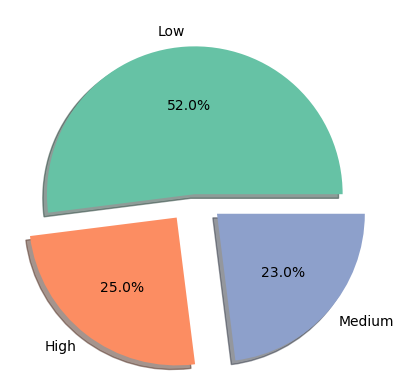

In [1044]:
#PLotting the classes distribuition
category_name = data[target_name].unique()
plt.pie(data[target_name].value_counts(), 
        labels = category_name,  
        shadow=True, 
        explode = [0,0.2,0.2],
        autopct='%1.1f%%',
       colors=sns.color_palette('Set2'))

plt.show()

* As expected, we have a class imbalance given our decision to classify the all the values bellow the mean as "Low" Diversity Index.

* To address this problem, we have used oversampling technique.

#### Oversampling

In [1047]:
#Removing target feature
X = data.drop(columns=[target_name])
y = data[target_name]

# Handle class imbalance using SMOTE with adjusted k_neighbors parameter
smote = SMOTE(random_state=42, k_neighbors=2)
X_resampled, y_resampled = smote.fit_resample(X, y)

#Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.25, random_state=42, stratify = y_resampled)

Class distribution after oversampling:

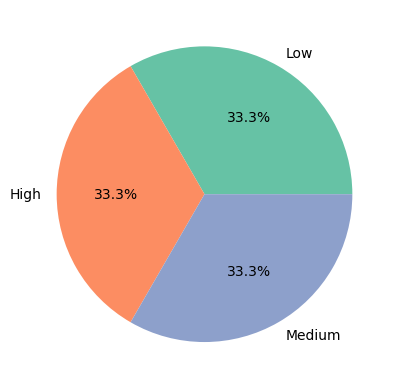

== Frequency:

Diversity Index Level
Low       1340
Medium    1340
High      1340
Name: count, dtype: int64


In [1049]:
#Plotting a pie chart with the classes distribuition

category_name = y_resampled.unique()
plt.pie(y_resampled.value_counts(), 
        labels = category_name,  
        autopct='%1.1f%%',
       colors=sns.color_palette('Set2'))
plt.show()

print("== Frequency:\n")
print(y_resampled.value_counts())

* Now that the class imbalance issue has been addressed, we check if the split of the dataset did not create any new disparity.

In [1051]:
print("Diversity_index (mean): \n")
print(f"Full Data Set: {X_resampled.transformed_right_Diversity_index.mean()}")
print(f"Test Data Set: {X_test.transformed_right_Diversity_index.mean()}")
print(f"Train Data Set: {X_train.transformed_right_Diversity_index.mean()}")

Diversity_index (mean): 

Full Data Set: 0.2493205896928778
Test Data Set: 0.2654786815958409
Train Data Set: 0.24393455905855682


##### Dropping Diversity_index

Diversity_index not needed anymore as it has now been discretized.

In [1054]:
X_test = X_test.drop("transformed_right_Diversity_index", axis = 1)
X_train = X_train.drop("transformed_right_Diversity_index", axis = 1)

# Model

* For this part, our initial approach is first start with a linear model, as it tends to have a lower computational cost.

* After that, we compare different non-linear models.

* Finally, we compare the results of the different models.

In [1057]:
#Models
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

#Reports
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

In [1058]:
# Support code that generates the classification report and saves the f1-score information for comparison later:

f1_scores = {}
#Generate classification report
def generate_classification_report(model_name, y_test, y_pred):
    report = classification_report(y_test, y_pred, output_dict=True)
    print(classification_report(y_test, y_pred))

    #Save F1 scores information for comparison
    f1_scores.update({model_name:{'High': report['High']['f1-score'],
      'Medium':  report['Medium']['f1-score'],
        'Low': report['Low']['f1-score']}})

## Linear Model

### Logistic Regression

In [1061]:
#Model initialization
logistic_regression_model = LogisticRegression(random_state= 45 ,max_iter=1000)

#Model training
logistic_regression_model.fit(X_train, y_train)

#Model testing
y_pred = logistic_regression_model.predict(X_test)

**Confusion Matrix (Logistic Regression):**

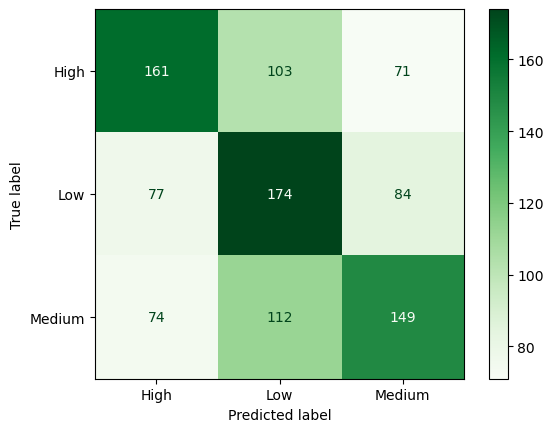

In [1063]:
#Generate confusion matrix
conf_matrix = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap = "Greens")

**Classification Report (Logistic Regression):**

In [1065]:
#report = classification_report(y_test, y_pred, output_dict=True)
generate_classification_report("Logistic Regression", y_test, y_pred)

              precision    recall  f1-score   support

        High       0.52      0.48      0.50       335
         Low       0.45      0.52      0.48       335
      Medium       0.49      0.44      0.47       335

    accuracy                           0.48      1005
   macro avg       0.48      0.48      0.48      1005
weighted avg       0.48      0.48      0.48      1005



**Conclusion:**

* The Logistic Regression model doesn't seem to fit the problem correctly which might indicate that a non-linear model might be more adequate.

* It's also possible that we are dealing with a non-linear dataset.

## Non-Linear Models

### Random Forest

In [1070]:
#Model initialization
random_forest_model = RandomForestClassifier(random_state= 99)

#Model training
random_forest_model.fit(X_train, y_train)

#Model testing
y_pred = random_forest_model.predict(X_test)

**Confusion Matrix (Random Forest):**

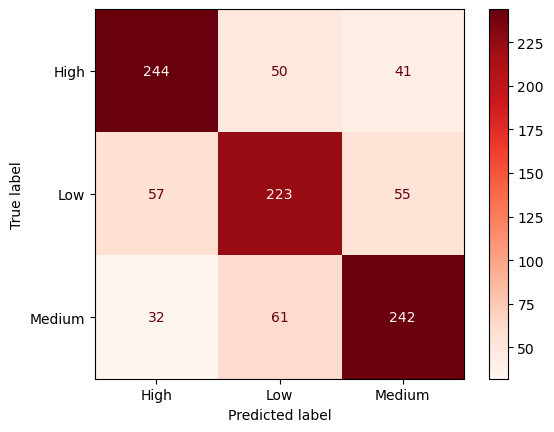

In [1072]:
#Generate confusion matrix
confusion_matrix = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap = "Reds")

**Classification Report (Random Forest):**

In [1074]:
#report = classification_report(y_test, y_pred)
generate_classification_report("Random Forest", y_test, y_pred)

              precision    recall  f1-score   support

        High       0.73      0.73      0.73       335
         Low       0.67      0.67      0.67       335
      Medium       0.72      0.72      0.72       335

    accuracy                           0.71      1005
   macro avg       0.71      0.71      0.71      1005
weighted avg       0.71      0.71      0.71      1005



**Conclusion (Random Forest):**

[TO-DO]

### Decision Tree

In [1078]:
#Model initialization
decision_tree_model = DecisionTreeClassifier(random_state= 49)

#Model training
decision_tree_model.fit(X_train, y_train)

#Model testing
y_pred = decision_tree_model.predict(X_test)

**Confusion Matrix (Decision Tree):**

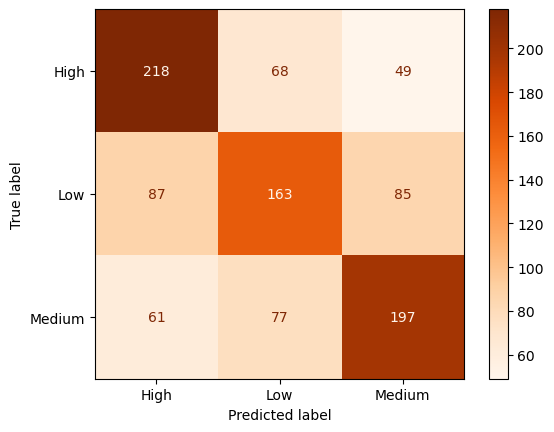

In [1080]:
#Generate confusion matrix
confusion_matrix = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap = "Oranges")

**Classification Report (Decision Tree):**

In [1082]:
generate_classification_report("Decision Tree", y_test, y_pred)

              precision    recall  f1-score   support

        High       0.60      0.65      0.62       335
         Low       0.53      0.49      0.51       335
      Medium       0.60      0.59      0.59       335

    accuracy                           0.58      1005
   macro avg       0.57      0.58      0.57      1005
weighted avg       0.57      0.58      0.57      1005



**Conclusion (Decision Tree):**

[TO-DO]

#### Multi-Layer Perceptron classifier

Finally, we compare it with a neural network model.

In [1087]:
#Model initialization
mlpc_model = MLPClassifier(hidden_layer_sizes=(15,20, 5),max_iter=1000, random_state = 49,  activation='tanh')

#Model training
mlpc_model.fit(X_train, y_train)

#Model testing
y_pred = mlpc_model.predict(X_test)

**Confusion Matrix (MLPC):**

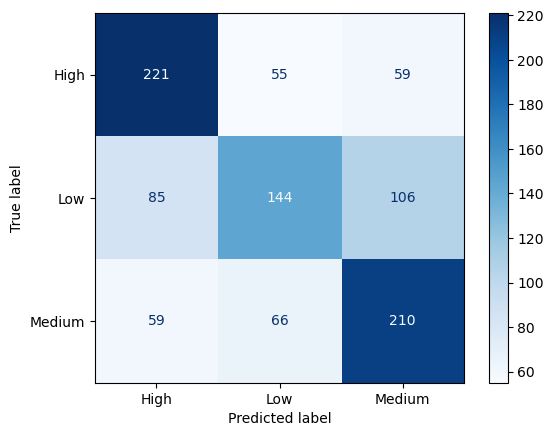

In [1089]:
#Generate confusion matrix
confusion_matrix = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap = "Blues")

**Classification Report (MLPC):**

In [1091]:
generate_classification_report("MLPC", y_test, y_pred)

              precision    recall  f1-score   support

        High       0.61      0.66      0.63       335
         Low       0.54      0.43      0.48       335
      Medium       0.56      0.63      0.59       335

    accuracy                           0.57      1005
   macro avg       0.57      0.57      0.57      1005
weighted avg       0.57      0.57      0.57      1005



**Conclusion (MLPC):**

[TO-DO]

### Comparison

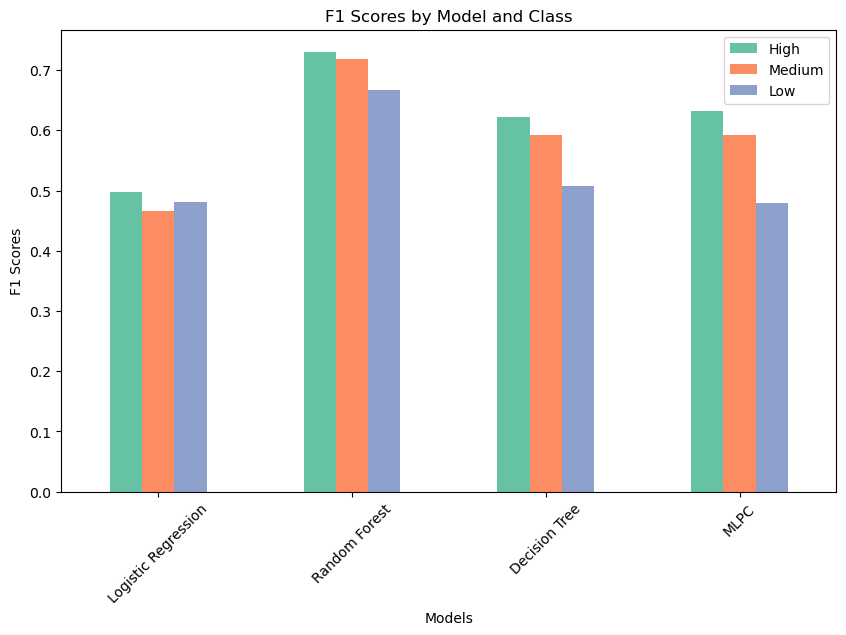

In [1095]:
#Transforming the dictionary into Data Frame
df_f1_scores = pd.DataFrame(f1_scores).T

f1_hist = df_f1_scores.plot(kind='bar', color = sns.color_palette('Set2', 3), figsize=(10, 6))

f1_hist.set_xlabel('Models')
f1_hist.set_ylabel('F1 Scores')
f1_hist.set_title('F1 Scores by Model and Class')


plt.xticks(rotation=45)
plt.show()

[TO-DO]